In [1]:
import numpy as np
import networkx as nx
from itertools import product
import numba as nb
import copy
import matplotlib.pyplot as plt
from scipy import optimize

# Trotterized Quantum Annealing Initialization for the QAOA

In the following we provide a brief tutorial for the Trotterized Quantum Annealing (TQA) initialization for
the QAOA. The initialization allows to circumvent convergence in local sub-optimal optima and achieves 
similar performance as the best of $2^p$ random initilizations.
For details see: https://arxiv.org/abs/2101.05742

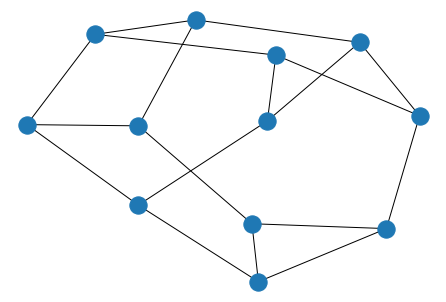

In [2]:
# Set everything up and show the graph
N = 12
seed = 50
G = nx.random_regular_graph(d=3, n=N, seed=seed)
edges = nx.edge_betweenness(G).keys()
nodes = G.nodes
nx.draw(G)
initial_state = np.ones(2 ** N) / np.sqrt(2) ** N
# Create full Hilbertspace to use in creation of the Hamiltonians
H = np.array(list(product([1, -1], repeat=N))) 

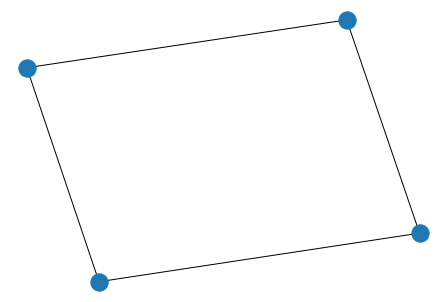

In [3]:
N = 4
G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3])
G.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 0)])
edges = nx.edge_betweenness(G).keys()
nodes = G.nodes
nx.draw(G)
initial_state = np.ones(2 ** N) / np.sqrt(2) ** N
# Create full Hilbertspace to use in creation of the Hamiltonians
H = np.array(list(product([1, -1], repeat=N))) 

In [4]:
# Fast Hadamard transformation

@nb.njit # Just in time compilation for massive speed-up
def fwht(a):
    h = 1
    tmp = a.copy()
    while 2 * h <= len(a):
        for i in range(0, len(a) - 1, h * 2):
            for j in range(i, i + h):
                x = tmp[j]
                y = tmp[j + h]
                tmp[j] = x + y
                tmp[j + h] = x - y
        h *= 2
    return tmp

def ifwht(a):
    return fwht(a) / len(a)

In [5]:
# Classical Hamiltonian, the ground state is the MaxCut solution
# we use the QAOA to find an approximation to the ground state variationally
def H_C():
    tmp = np.zeros(2**N)
    for i, j in edges:
        tmp += H[:, i] * H[:, j]
    return tmp

In [24]:
# Quantum Hamiltonian, the ground state is an equal superposition of all solutions, i.e. all possible graph cuts
def H_B():
    tmp = np.zeros(2**N)
    for i in nodes:
        tmp += H[:, i]
    return tmp

for i in range(4):
    for j in range(4):
        print(H_B()[4*i+j], end='  ')
    print()

4.0  2.0  2.0  0.0  
2.0  0.0  0.0  -2.0  
2.0  0.0  0.0  -2.0  
0.0  -2.0  -2.0  -4.0  


In [7]:
def qaoa_state(x):

    # Create the QAOA ansatz state, note that we use a fast Hadamard 
    # transformation (n log(n)) to keep the operators diagonal and use vector-vector 
    # multiplication rather than matrix-vector mutliplication where the 
    # matrix would be the matrix exponential of H_B which would be very slow

    beta, gamma = np.split(x, 2)
    state = copy.copy(initial_state)

    for g, b in zip(gamma, beta):

        state = np.exp(1j * g * H_C()) * state
        state = fwht(state)              # Fast Hadamard transformation
        state = np.exp(-1j * b * H_B()) * state
        state = ifwht(state)             # inverse Fast Hadamard transformation

    return state

In [8]:
def energy_expectation_value(state):
    return np.real(np.vdot(state, H_C() * state))

# Find the optimal Trotter time step

In [9]:
# Loop over different evolution times
time = np.linspace(0.1, 4, 20)

energies = []
for p in [3, 4]:
    energy = []
    for t_max in time: 
        
        dt = t_max / p
        t = dt * (np.arange(1, p + 1) - 0.5)
        gamma = (t / t_max) * dt
        beta = (1 - (t / t_max)) * dt
        x = np.concatenate((beta, gamma))
        energy.append(energy_expectation_value(qaoa_state(x)))

    energies.append(energy)

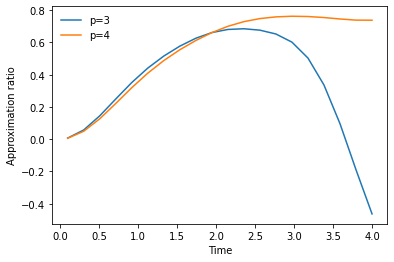

In [10]:
plt.plot(time, energies[0]/min(H_C()), label="p=3")
plt.plot(time, energies[1]/min(H_C()), label="p=4")
plt.xlabel('Time')
plt.ylabel('Approximation ratio')
plt.legend(frameon=False)

In [11]:
# Find optimal time 
idx = np.argmin(energies[1])
t_max = time[idx]
print(f'Optimal evolution time is {t_max} with an approximation ratio of {energies[1][idx]/min(H_C())}')

Optimal evolution time is 2.973684210526316 with an approximation ratio of 0.7626659375378437


# Launch QAOA from TQA initialization

In [12]:
# Fix initial beta and gamma values
p = 4
dt = t_max / p
t = dt * (np.arange(1, p + 1) - 0.5)
gamma = (t / t_max) * dt
beta = (1 - (t / t_max)) * dt
x0 = np.concatenate((beta, gamma))

In [13]:
func_to_optimize = lambda x: energy_expectation_value(qaoa_state(x))
result_tqa = optimize.minimize(func_to_optimize, x0, method='BFGS')

In [14]:
result_tqa

      fun: -3.999999999999753
 hess_inv: array([[ 0.57732964,  0.03868857,  0.04238237, -0.06287307,  0.03236419,
        -0.04063095, -0.05946407, -0.39601538],
       [ 0.03868857,  0.02568332, -0.01661333, -0.02006765,  0.00609321,
         0.00417739, -0.00342902, -0.05940907],
       [ 0.04238237, -0.01661333,  0.32436055,  0.22616627, -0.250003  ,
        -0.28069636,  0.00412214, -0.0406171 ],
       [-0.06287307, -0.02006765,  0.22616627,  0.25188098, -0.17138436,
        -0.24994835,  0.0061762 ,  0.03222131],
       [ 0.03236419,  0.00609321, -0.250003  , -0.17138436,  0.25198119,
         0.22607437, -0.02003806, -0.0626658 ],
       [-0.04063095,  0.00417739, -0.28069636, -0.24994835,  0.22607437,
         0.32443478, -0.01662147,  0.04228292],
       [-0.05946407, -0.00342902,  0.00412214,  0.0061762 , -0.02003806,
        -0.01662147,  0.02573676,  0.03861966],
       [-0.39601538, -0.05940907, -0.0406171 ,  0.03222131, -0.0626658 ,
         0.04228292,  0.03861966,  0.57

In [15]:
print(f'Final approximation ratio from TQA init. is {result_tqa.fun/min(H_C())}')

Final approximation ratio from TQA init. is 0.9999999999999383


In [16]:
# Quick comparison with a single QAOA run lauched from a random initialization
x0_random = np.concatenate((np.random.uniform(-np.pi/4, np.pi/4, p), np.random.uniform(-np.pi/2, np.pi/2, p)))
result_rand = optimize.minimize(func_to_optimize, x0_random, method='BFGS')

In [17]:
result_rand

      fun: -3.999999999999969
 hess_inv: array([[ 0.25745073,  0.14310178, -0.03667157, -0.08027297, -0.07520177,
         0.33920677, -0.05863028, -0.06660543],
       [ 0.14310178,  0.27339278, -0.23081516, -0.03293055, -0.05898686,
         0.07656954, -0.00165034,  0.04945278],
       [-0.03667157, -0.23081516,  0.28263165, -0.05454861,  0.08279433,
         0.11017585, -0.0960307 , -0.07981521],
       [-0.08027297, -0.03293055, -0.05454861,  0.13614642, -0.13779206,
        -0.11405764,  0.14397885,  0.03137427],
       [-0.07520177, -0.05898686,  0.08279433, -0.13779206,  0.4677078 ,
        -0.15336968, -0.20699981, -0.06575498],
       [ 0.33920677,  0.07656954,  0.11017585, -0.11405764, -0.15336968,
         0.63093663, -0.18000129, -0.09368086],
       [-0.05863028, -0.00165034, -0.0960307 ,  0.14397885, -0.20699981,
        -0.18000129,  0.49147434, -0.14230625],
       [-0.06660543,  0.04945278, -0.07981521,  0.03137427, -0.06575498,
        -0.09368086, -0.14230625,  0.21

In [18]:
print(f'Final approximation ratio from random init. is {result_rand.fun/min(H_C())}')

Final approximation ratio from random init. is 0.9999999999999922


For a thorough performance comparison between random and TQA initialization, check out the paper.